Enter names of students working in a team of two here: [Tong Li] [Ning Liang]

# NUC Exercise #2 – Quantitative PET Data Analysis

The purpose of the exercise is to implement and study kinetic modeling and data fitting for quantitative PET data analysis of 18F-FDG tracer experiments.

## Imports

In [2]:
from sympy import symbols, Eq, Function
from sympy.solvers.ode.systems import dsolve_system
from scipy.signal import lfilter
from scipy.optimize import curve_fit

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats 

%matplotlib inline

## Section 1 - Defining the system

Upon injection, $^{18}$F-FDG is taken up by tissue via glucose transporters and converted to $^{18}$F-FDG-6-phosphate ($^{18}$F-FDG-6-P) as shown schematically in the figure below. For the analysis of rate constants ($k_1$, $k_2$, $k_3$, $k_4$) we consider the two tissue compartments ($c_e$, $c_m$) and treat the blood/plasma compartment ($c_p$) separately, i.e. we solve the equations for an ideal delta input function (impulse response) and convolve the results with the actual input signals.

![figure1](figure1.png)

####  Task 1.1

> Derive and write down the differential equations for the concentrations of extracellular ($c_e(t)$) and metabolized $^{18}$F-FDG ($c_m(t)$); assume that the input from the blood plasma is a delta function, i.e. $c_e(0) = k_1\cdot[min\cdot ml/g]$ and $c_m(0) = 0$, also assume $k_4=0$.

*Type your answer here*
$$\frac{dc_e}{dt}=-k_2c_e(t)-k_3c_e(t)$$
$$\frac{dc_m}{dt}=k_3c_e(t)$$

## Section 2 - Solving the system

A python library called SymPy will be used for symbolic mathematics, more information can be found on https://docs.sympy.org/latest/modules/solvers/ode.html.

####  Task 2.1
> Write and solve the differential equations derived above using symbolic maths to obtain the impulse response functions of the extracellular compartment $c_e(t)$ and the metabolized compartment $c_m(t)$.

In [3]:
# TASK: Define constants 
k1, k2, k3 = symbols('k1 k2 k3')

# TASK: Define dependent variables
ce, cm = symbols('ce cm', cls=Function)

# TASK: Define independent variable
t = symbols('t')

# TASK: Define the system
eqs = [Eq(ce(t).diff(t), -k2*ce(t) - k3*ce(t)), 
       Eq(cm(t).diff(t), k3*ce(t))]
ics = {ce(0): k1, 
       cm(0): 0}

# Solve system of equations
h = dsolve_system(eqs, ics=ics)
h_ce = h[0][0].rhs
h_cm = h[0][1].rhs
print("h_e(t) = ", h_ce)
print("h_m(t) = ", h_cm)

h_e(t) =  k1*exp(-t*(k2 + k3))
h_m(t) =  k1*k3/(k2 + k3) - k1*k3*exp(-t*(k2 + k3))/(k2 + k3)


#### Task 2.2
> Fill in the parameters to the found solutions and define the input function as an ideal delta pulse. Assume the following constants: $k_1=0.1 \text{min}^{-1}$, $k_2=0.3 \text{min}^{-1}$, $k_3=0.5 \text{min}^{-1}$.

In [4]:
# TASK: Fill in the parameters
time = np.arange(0, 240)  # s
h_e, h_m = np.zeros(time.shape), np.zeros(time.shape)

for i, tt in enumerate(time):  
    val_h_e = h_ce.subs(k1, 0.0017).subs(k2,0.005).subs(k3, 0.0083).subs(t, tt)
    val_h_m = h_cm.subs(k1, 0.0017).subs(k2, 0.005).subs(k3,0.0083).subs(t, tt)
    
    h_e[i] = val_h_e
    h_m[i] = val_h_m

# Define input plasma curve
cp = stats.gamma.pdf(time, a=2, scale=10) 
cp = cp/np.max(cp)  # conc-time curve of cp

#### Task 2.3
> Implement convolution of the impulse response functions with the blood plasma input curve $c_p(t)$.

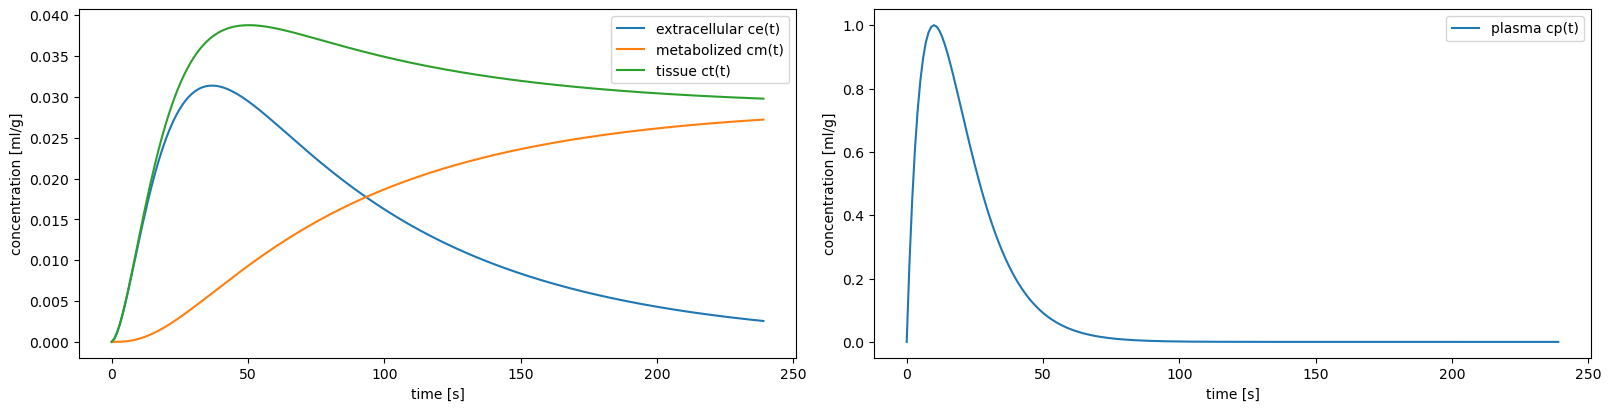

In [5]:
# TASK: Filtering
ce = lfilter(h_e,[1], cp)  # conc-time curve of ce  
cm = lfilter(h_m,[1],cp)  # conc-time curve of cm

# TASK: Compute tissue concentration ct(t)
ct =ce+cm            

# Visualize the results
fig, axes = plt.subplots(1, 2, figsize=(16, 4), constrained_layout=True)
axes[0].plot(time, ce, label="extracellular ce(t)")
axes[0].plot(time, cm, label="metabolized cm(t)")
axes[0].plot(time, ct, label="tissue ct(t)")
axes[0].legend();
axes[0].set_xlabel('time [s]')
axes[0].set_ylabel('concentration [ml/g]')

axes[1].plot(time, cp, label="plasma cp(t)")
axes[1].legend();
axes[1].set_xlabel('time [s]')
axes[1].set_ylabel('concentration [ml/g]');

#### Task 2.4
> Rate constant $k_4$ was assumed to be zero – justify why such an assumption is valid by considering the process of $^{18}$F-FDG tracer uptake and metabolization in tumors. 

*Type your answer here* :It is much easier for radiotracer to combine with receptors than disassociation .So K3>>K4 ,we can negkect K4.

## Section 3 - Fitting to noisy measurements

In a real-word experiment, blood plasma concentration $c_p(t)$ is measured in a blood vessel near the tissue of interest ($c_e(t) + c_m(t)$) and both measurements are input to a fitting procedure to obtain the kinetic rate constants ($k_1$, $k_2$, $k_3$).

#### Task 3.1
> Add Poisson noise to $c_p(t)$ and $c_t(t)$ by converting concentrations into photon counts such as to obtain a peak SNR of 100 of the blood plasma signal; inspect the resulting concentration-time curves

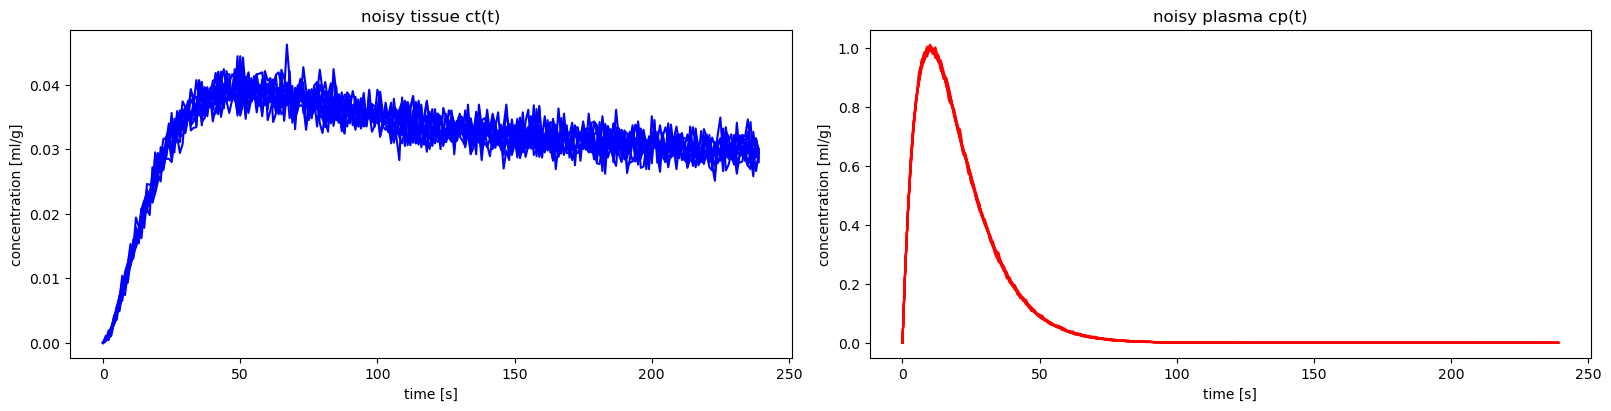

In [6]:
SNR = 100
niter = 10

fig, axes = plt.subplots(1, 2, figsize=(16, 4), constrained_layout=True)
for i in range(niter):
    # TASK: Convert concentrations into counts N 
    N0 = SNR**2  # SNR = sqrt(N0)
    Ncp = N0*cp
    Nct = N0*ct

    # TASK: Add Poisson noise to cp(t) and ct(t) 
    Ncp = np.random.poisson(Ncp)
    Nct = np.random.poisson(Nct)

    # TASK: Convert from counts N back to concentrations 
    cp_noise = Ncp/N0
    ct_noise = Nct/N0

    # Visualize the results    
    axes[0].plot(time, ct_noise, c='b')
    axes[1].plot(time, cp_noise, c='r')

axes[0].set_xlabel('time [s]')
axes[0].set_ylabel('concentration [ml/g]')
axes[0].set_title('noisy tissue ct(t)')
axes[1].set_xlabel('time [s]')
axes[1].set_ylabel('concentration [ml/g]');
axes[1].set_title('noisy plasma cp(t)');

#### Task 3.2
> Implement the fit function to determine the rate constants ($k_1$, $k_2$, $k_3$) from noisy $c_t(t)$ and $c_p(t)$ input.

Estimated rate constants (k1, k2, k3):  [0.10230289 0.31493031 0.53938429]  [1/min]
Estimated rate constants (k1, k2, k3):  [0.10112765 0.30863948 0.53063685]  [1/min]
Estimated rate constants (k1, k2, k3):  [0.10381021 0.33909924 0.56837849]  [1/min]
Estimated rate constants (k1, k2, k3):  [0.10236061 0.28513319 0.47230742]  [1/min]
Estimated rate constants (k1, k2, k3):  [0.10254352 0.30027626 0.48866861]  [1/min]


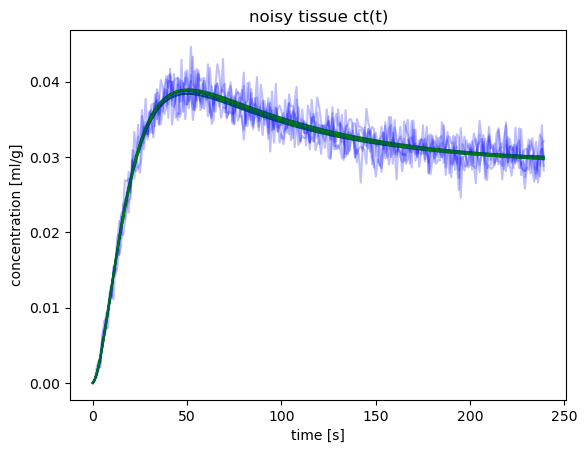

In [7]:
SNR = 100
niter = 5 

# TASK: Filtering (rate constants should be variable)
def var_filter(time, k11, k22, k33):    
    h_ct = h_cm + h_ce
    ct = np.zeros(time.shape)
    for i, tt in enumerate(time):  
        val_ct = h_ct.subs(k1, k11).subs(k2, k22).subs(k3, k33).subs(t, tt)
        ct[i] = val_ct
    
    return lfilter(cp_noise, 1, ct)

k_result = np.zeros((niter, 3))
for i in range(niter):
    # TASK: Convert concentrations into counts N 
    N0 = SNR**2  # SNR = sqrt(N0)
    Ncp = N0*cp
    Nct = N0*ct

    # TASK: Add Poisson noise to cp(t) and ct(t) 
    Ncp = np.random.poisson(Ncp)
    Nct = np.random.poisson(Nct)

    # TASK: Convert from counts N back to concentrations 
    cp_noise = Ncp/N0
    ct_noise = Nct/N0
    
    # TASK: Estimate rate contstants using a (damped) least-squares method
    popt, _ = curve_fit(var_filter, time, ct_noise, p0=np.array([0.01, 0.01, 0.01]))

    # Save, print, and visualize the results
    k_result[i, :] = [popt[0]*60, popt[1]*60, popt[2]*60]
    print("Estimated rate constants (k1, k2, k3): ", k_result[i, :], " [1/min]")
    plt.plot(time, var_filter(time, popt[0], popt[1], popt[2]), c='g')
    plt.plot(time, ct_noise, c='b', alpha=0.25)

plt.xlabel('time [s]')
plt.ylabel('concentration [ml/g]')
plt.title('noisy tissue ct(t)');

#### Task 3.3
> Determine mean, standard deviation, and the coefficient of variation (CoV) of the fitted rate constants ($k_1$, $k_2$, $k_3$) for multiple repetitions of adding noise and fitting the noisy data.

In [8]:
# TASK: Print statistics
print("Mean rate constants (k1, k2, k3): {:.2f}, {:.2f}, {:.2f} [1/min]".format(np.mean(k_result[:, 0]), np.mean(k_result[:, 1]), np.mean(k_result[:, 2])))
print("StDev rate constants (k1, k2, k3): {:.2f}, {:.2f}, {:.2f} [1/min]".format(np.std(k_result[:, 0], ddof=0), np.std(k_result[:, 1], ddof=0), np.std(k_result[:, 2], ddof=0)))

Mean rate constants (k1, k2, k3): 0.10, 0.31, 0.52 [1/min]
StDev rate constants (k1, k2, k3): 0.00, 0.02, 0.03 [1/min]


#### Task 3.4
> Reduce the SNR by a factor 10 and repeat the experiments above; how do mean and standard deviation of fitted rate constants change? Which conclusion do you draw in terms of required signal-to-noise ratio of the input PET data?

*Type your answer here* :Standard deviation increase.High SNR is required.